In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
import os
from scipy.stats import spearmanr
from matplotlib.lines import Line2D
import joypy

In [4]:
def load_config(yaml_path="P4-config.yaml"):
    with open(yaml_path, "r", encoding="utf-8") as f:
        return yaml.safe_load(f)
    
config = load_config()

In [5]:
# MODEL CHOICE
model = "llama" # or llama
if model == "biomistral":
    input_file_path = "input_file_paths_biomistral"
    prompts_dir = "prompts_dir_biomistral"
    output_dir = "output_file_paths_biomistral"

elif model == "llama":
    input_file_path = "input_file_paths_llama"
    prompts_dir = "prompts_dir_llama"
    output_dir = "output_file_paths_llama"

In [6]:
deepseek_output_path = config[output_dir]["deepseek_ratings_output_dir"]
o4_mini_output_path =  config[output_dir]["chatgpt_ratings_output_dir"]

o4_mini_basic_path = os.path.join(o4_mini_output_path, "basic_realworld_test")
o4_mini_basic = pd.read_csv(os.path.join(o4_mini_basic_path, "chatgpt_ratings_basic_realworld_test.csv"))
deepseek_basic_path = os.path.join(deepseek_output_path, "basic_realworld_test")
deepseek_basic = pd.read_csv(os.path.join(deepseek_basic_path, "deepseek_ratings_basic_realworld_test.csv"))

o4_mini_oncology_path = os.path.join(o4_mini_output_path, "onco_realworld_test")
o4_mini_onco = pd.read_csv(os.path.join(o4_mini_oncology_path, "chatgpt_ratings_onco_realworld_test.csv"))
deepseek_onco_path = os.path.join(deepseek_output_path, "onco_realworld_test")
deepseek_onco = pd.read_csv(os.path.join(deepseek_onco_path, "deepseek_ratings_onco_realworld_test.csv"))

o4_mini_reviewer_path = os.path.join(o4_mini_output_path, "reviewer_realworld_test")
o4_mini_reviewer = pd.read_csv(os.path.join(o4_mini_reviewer_path, "chatgpt_ratings_reviewer_realworld_test.csv"))
deepseek_reviewer_path = os.path.join(deepseek_output_path, "reviewer_realworld_test")
deepseek_reviewer = pd.read_csv(os.path.join(deepseek_reviewer_path, "deepseek_ratings_reviewer_realworld_test.csv"))


In [7]:
o4_mini_basic.head()

,record_id,Drug,Summary,accurate,organized,comprehensible,succinct
0,0,Metformin,")<Output>\n{{\n ""Mechanism"": ""<Metformin targ...",2,5,4,5
1,1,Pioglitazone,")<Output format>\n{{\n ""Mechanism"": ""<Pioglit...",1,5,5,4
2,2,Alogliptin,")<Output format>\n{{\n ""Mechanism"": ""<Aloglip...",5,5,5,2
3,3,Linagliptin,")<Output format>\n{{\n ""Mechanism"": ""<Linagli...",1,5,5,3
4,4,Sitagliptin,")<Output format>\n{{\n ""Mechanism"": ""<Sitagli...",1,1,2,1


## Simple statistics

In [8]:
def get_stats(df):
    categories = ["accurate", "organized", "comprehensible", "succinct"]

    stats_df = pd.DataFrame({
        "average": df[categories].mean(),
        "median": df[categories].median(),
        "std_dev": df[categories].std()
    })

    return stats_df


In [9]:
def compare(o4_df, deep_df):
    o4_stats = get_stats(o4_df)
    deep_stats = get_stats(deep_df)
    merged = pd.concat({"o4_mini": o4_stats["average"],
                        "deepseek": deep_stats["average"]}, axis=1)
    return merged

basic_compare = compare(o4_mini_basic, deepseek_basic)
onco_compare = compare(o4_mini_onco, deepseek_onco)
reviewer_compare = compare(o4_mini_reviewer, deepseek_reviewer)


In [10]:
print("Basic compare:")
print(basic_compare)

print("\nOncology compare:")
print(onco_compare)

print("\nReviewer compare:")
print(reviewer_compare)


Basic compare:
                 o4_mini  deepseek
accurate        1.896552  3.000000
organized       3.965517  3.083333
comprehensible  4.068966  4.583333
succinct        3.034483  3.250000

Oncology compare:
                 o4_mini  deepseek
accurate        2.068966  2.363636
organized       3.344828  3.545455
comprehensible  3.379310  4.000000
succinct        2.241379  2.272727

Reviewer compare:
                 o4_mini  deepseek
accurate        3.172414  3.090909
organized       2.379310  2.545455
comprehensible  3.517241  3.636364
succinct        2.344828  2.000000


In [11]:
def get_std(o4_df, deep_df):
    o4_stats = get_stats(o4_df)
    deep_stats = get_stats(deep_df)
    merged = pd.concat({"o4_mini": o4_stats["std_dev"],
                        "deepseek": deep_stats["std_dev"]}, axis=1)
    return merged

basic_std = get_std(o4_mini_basic, deepseek_basic)
onco_std = get_std(o4_mini_onco, deepseek_onco)
reviewer_std = get_std(o4_mini_reviewer, deepseek_reviewer)

print("Basic std dev:")
print(basic_std)

print("\nOncology std dev:")
print(onco_std)

print("\nReviewer std dev:")
print(reviewer_std)

Basic std dev:
                 o4_mini  deepseek
accurate        1.234759  1.477098
organized       1.475581  1.443376
comprehensible  1.032716  0.668558
succinct        1.209568  1.544786

Oncology std dev:
                 o4_mini  deepseek
accurate        1.437533  1.206045
organized       1.609700  1.507557
comprehensible  1.293218  1.612452
succinct        1.023131  1.272078

Reviewer std dev:
                 o4_mini  deepseek
accurate        1.891125  1.700267
organized       1.399331  1.368476
comprehensible  1.639266  1.566699
succinct        1.316811  1.414214


In [12]:
# find outliers
def find_outliers(df):
    categories = ["accurate", "organized", "comprehensible", "succinct"]
    
    # store all outlier drug names
    all_outliers = set()

    for category in categories:
        mean = df[category].mean()
        std_dev = df[category].std()
        threshold = mean - 2 * std_dev

        # find drugs below threshold
        outliers = df[df[category] < threshold]["Drug"].tolist()

        # add them to the global set of outliers
        all_outliers.update(outliers)

    return list(all_outliers)


basic_o4_outliers = find_outliers(o4_mini_basic)
basic_deep_outliers = find_outliers(deepseek_basic)

onco_o4_outliers = find_outliers(o4_mini_onco)
onco_deep_outliers = find_outliers(deepseek_onco)

reviewer_o4_outliers = find_outliers(o4_mini_reviewer)
reviewer_deep_outliers = find_outliers(deepseek_reviewer)




In [13]:
print(basic_o4_outliers)
print(basic_deep_outliers)
print(onco_o4_outliers)
print(onco_deep_outliers)
print(reviewer_o4_outliers)
print(reviewer_deep_outliers)

['Lixisenatide', 'Tirzepatide', 'Sitagliptin', 'Saxagliptin']
['Saxagliptin']
[]
[]
[]
[]


In [14]:
basic_o4_mini_stats = get_stats(o4_mini_basic)
basic_deepseek_stats = get_stats(deepseek_basic)
onco_o4_mini_stats = get_stats(o4_mini_onco)
onco_deepseek_stats = get_stats(deepseek_onco)
reviewer_o4_mini_stats = get_stats(o4_mini_reviewer)
reviewer_deepseek_stats = get_stats(deepseek_reviewer)

### add token len

In [15]:
def add_token_len(df, text_col="Summary"):
    # safe string + approximate tokens
    s = df[text_col].fillna("").astype(str)
    df = df.copy()
    df["n_tokens"] = (s.str.len() / 4).round().astype(int)
    return df


o4_mini_basic = add_token_len(o4_mini_basic)
deepseek_basic = add_token_len(deepseek_basic)

o4_mini_onco = add_token_len(o4_mini_onco)
deepseek_onco = add_token_len(deepseek_onco)

o4_mini_reviewer = add_token_len(o4_mini_reviewer)
deepseek_reviewer = add_token_len(deepseek_reviewer)


In [16]:
def to_long(df, dataset_name, model_name):
    categories = ["accurate", "organized", "comprehensible", "succinct"]
    out = df[["Drug", "record_id", "n_tokens", *categories]].copy()
    out["Dataset"] = dataset_name
    out["Model"] = model_name
    return out

all_df = pd.concat([
    to_long(o4_mini_basic, "Basic", "o4-mini"),
    to_long(deepseek_basic, "Basic", "DeepSeek"),
    to_long(o4_mini_onco, "Onco", "o4-mini"),
    to_long(deepseek_onco, "Onco", "DeepSeek"),
    to_long(o4_mini_reviewer, "Reviewer", "o4-mini"),
    to_long(deepseek_reviewer, "Reviewer", "DeepSeek"),
], ignore_index=True)

plot_df = all_df.melt(
    id_vars=["Drug", "record_id", "n_tokens", "Dataset", "Model"],
    value_vars=["accurate", "organized", "comprehensible", "succinct"],
    var_name="Metric",
    value_name="Score"
).dropna()


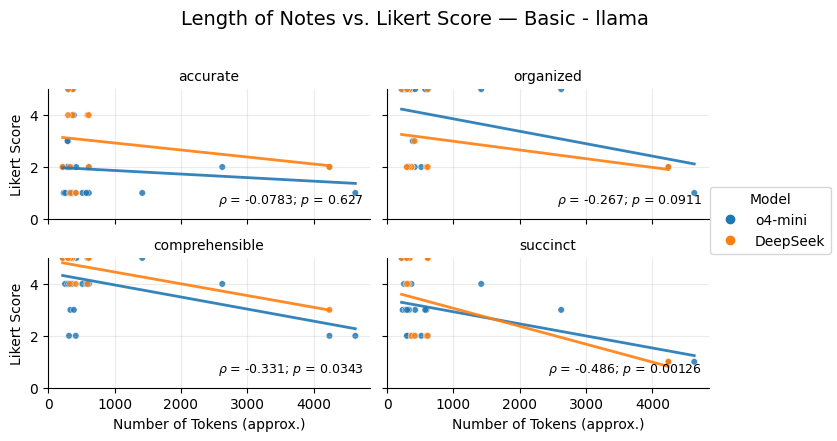

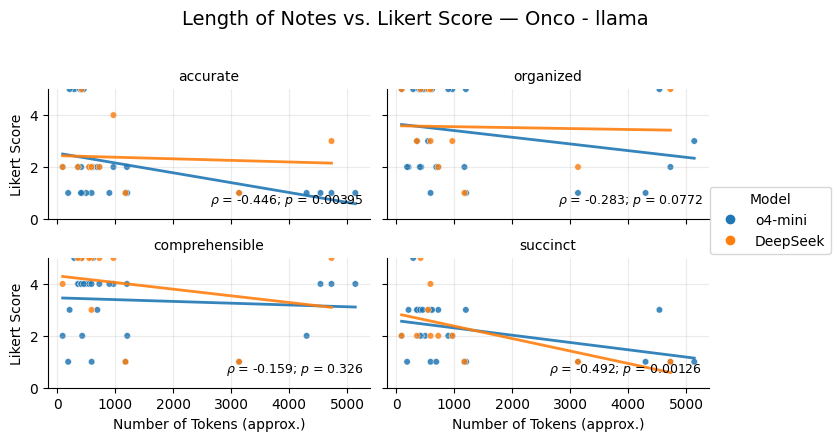

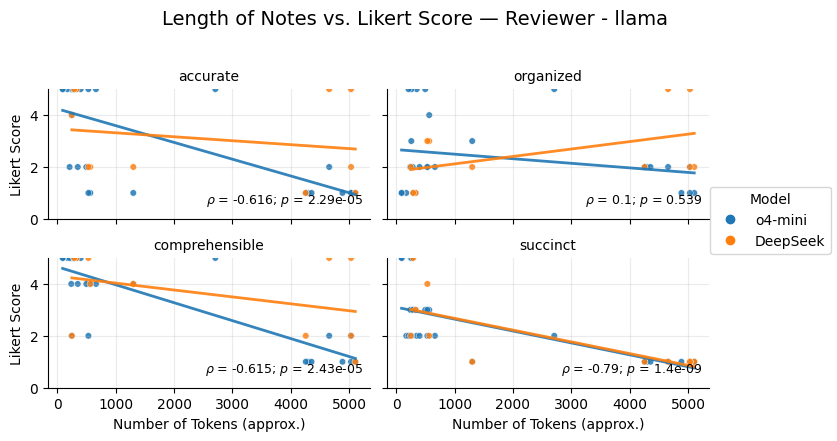

In [17]:
def plot_tokens_vs_score_by_dataset(plot_df, dataset_name, spearman_mode="pooled"):
    """
    spearman_mode: "pooled" or "per_model"
    """
    df = plot_df[plot_df["Dataset"] == dataset_name].copy()
    metrics = ["accurate", "organized", "comprehensible", "succinct"]

    # Keep model colors consistent everywhere
    models = list(df["Model"].dropna().unique())
    palette = dict(zip(models, sns.color_palette(n_colors=len(models))))

    g = sns.FacetGrid(
        df, col="Metric", col_wrap=2, height=2.1, aspect=2.0,
        sharex=True, sharey=True
    )

    def panel(data, **kws):
        ax = plt.gca()

        # scatter by model (NO legend here; we'll add one global legend)
        sns.scatterplot(
            data=data, x="n_tokens", y="Score",
            hue="Model", palette=palette,
            alpha=0.85, s=22, ax=ax, legend=False
        )

        # regression line per model, matching colors
        for model in data["Model"].dropna().unique():
            sub = data[data["Model"] == model]
            sns.regplot(
                data=sub, x="n_tokens", y="Score",
                scatter=False, ci=None, ax=ax,
                color=palette[model],
                line_kws={"linewidth": 2, "alpha": 0.9}
            )

        # Spearman annotation
        if spearman_mode == "pooled":
            rho, p = spearmanr(data["n_tokens"], data["Score"], nan_policy="omit")
            txt = f"$\\rho$ = {rho:.3g}; $p$ = {p:.3g}"
        else:
            parts = []
            for model in data["Model"].dropna().unique():
                sub = data[data["Model"] == model]
                rho, p = spearmanr(sub["n_tokens"], sub["Score"], nan_policy="omit")
                parts.append(f"{model}: $\\rho$={rho:.2g}, p={p:.2g}")
            txt = "\n".join(parts)

        ax.text(0.98, 0.08, txt, transform=ax.transAxes,
                ha="right", va="bottom", fontsize=9)

        ax.set_ylim(0, 5)
        ax.grid(True, alpha=0.25)

    g.map_dataframe(panel)
    g.set_axis_labels("Number of Tokens (approx.)", "Likert Score")
    g.set_titles("{col_name}")
    g.fig.suptitle(f"Length of Notes vs. Likert Score — {dataset_name} - {model}", y=1.04, fontsize=14)

    # Global legend (custom handles so it always shows)
    import matplotlib.lines as mlines
    handles = [mlines.Line2D([], [], color=palette[m], marker='o', linestyle='None',
                             markersize=6, label=m) for m in models]
    g.fig.legend(handles=handles, title="Model", loc="center right", frameon=True)
    g.fig.subplots_adjust(right=0.85, top=0.85)  # make room for legend + title

    plt.show()

plot_tokens_vs_score_by_dataset(plot_df, "Basic", spearman_mode="pooled")
plot_tokens_vs_score_by_dataset(plot_df, "Onco", spearman_mode="pooled")
plot_tokens_vs_score_by_dataset(plot_df, "Reviewer", spearman_mode="pooled")


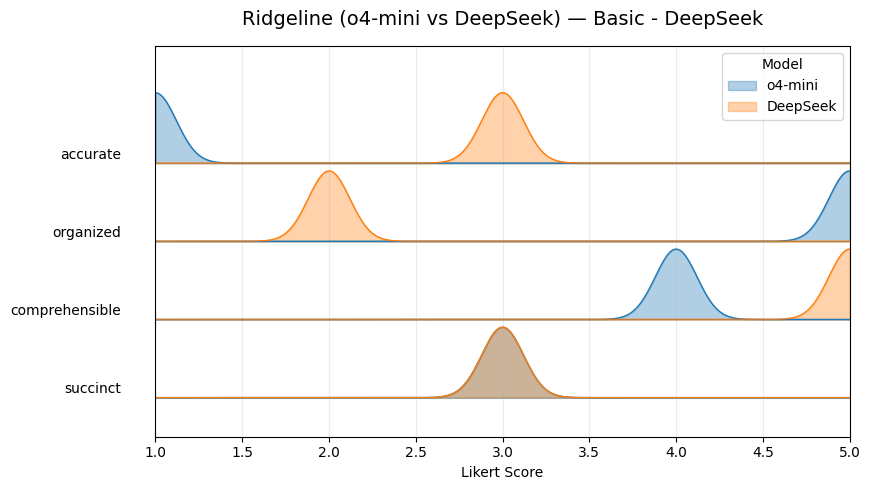

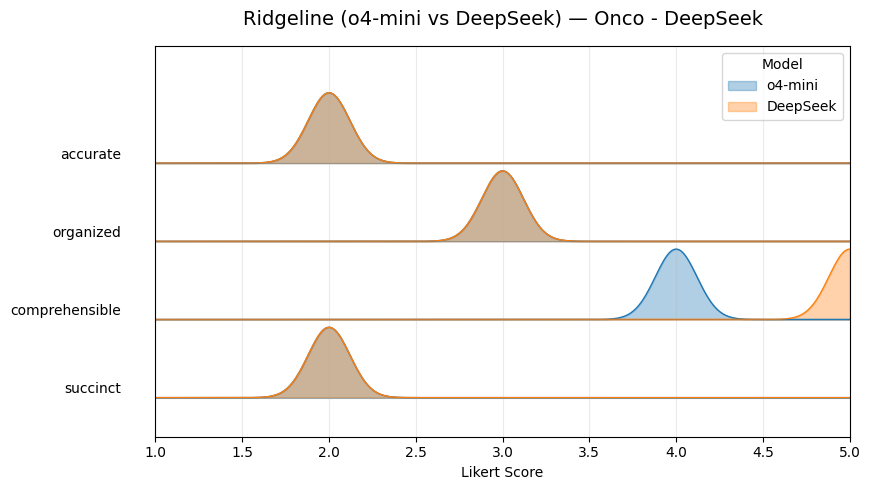

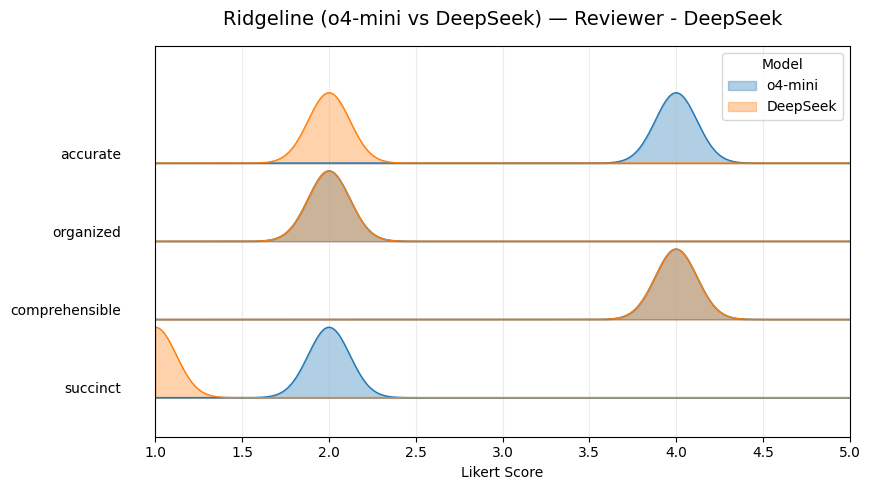

In [21]:

def plot_ridgeline_overlay_models(plot_df, dataset_name,
                                 metrics=("accurate","organized","comprehensible","succinct"),
                                 score_col="Score", metric_col="Metric", model_col="Model",
                                 x_min=1, x_max=5, bw=0.35, height=0.9, alpha=0.35,
                                 min_n=3, eps=1e-6, bump_sigma=0.12):
    """
    - Handles zero-variance groups by drawing a small Gaussian 'bump' at the constant score.
    - min_n: minimum points to attempt KDE; otherwise fallback to bump.
    """

    df = plot_df[plot_df["Dataset"] == dataset_name].copy()
    df = df[df[metric_col].isin(metrics)].copy()
    df[score_col] = pd.to_numeric(df[score_col], errors="coerce")
    df = df.dropna(subset=[score_col, metric_col, model_col])

    metric_order = list(metrics)
    models = list(df[model_col].dropna().unique())
    palette = dict(zip(models, sns.color_palette(n_colors=len(models))))

    xs = np.linspace(x_min, x_max, 400)

    fig, ax = plt.subplots(figsize=(8.8, 5.0))

    for i, metric in enumerate(metric_order):
        base = len(metric_order) - 1 - i
        sub_m = df[df[metric_col] == metric]

        for model in models:
            vals = sub_m.loc[sub_m[model_col] == model, score_col].values.astype(float)

            if len(vals) < 1:
                continue

            # If too few points OR nearly constant -> fallback bump
            if len(vals) < min_n or np.nanstd(vals) < eps:
                mu = float(np.nanmedian(vals))
                ys = np.exp(-0.5 * ((xs - mu) / bump_sigma) ** 2)
            else:
                # KDE with safety try/except
                try:
                    kde = gaussian_kde(vals, bw_method=bw)
                    ys = kde(xs)
                except Exception:
                    mu = float(np.nanmedian(vals))
                    ys = np.exp(-0.5 * ((xs - mu) / bump_sigma) ** 2)

            # Normalize ridge height
            ys = ys / (ys.max() if ys.max() > 0 else 1.0)

            y = base + ys * height
            ax.fill_between(xs, base, y, alpha=alpha, linewidth=1,
                            label=model if i == 0 else None, color=palette[model])
            ax.plot(xs, y, linewidth=1, color=palette[model])

        ax.hlines(base, x_min, x_max, linewidth=0.8, alpha=0.25)
        ax.text(x_min - 0.05*(x_max-x_min), base + 0.02, metric,
                ha="right", va="bottom", fontsize=10)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(-0.5, len(metric_order) - 0.5 + height + 0.1)
    ax.set_yticks([])
    ax.set_xlabel("Likert Score")
    ax.set_title(f"Ridgeline (o4-mini vs DeepSeek) — {dataset_name} - {model}", fontsize=14, pad=15)
    ax.grid(True, axis="x", alpha=0.25)
    ax.legend(title="Model", loc="upper right", frameon=True)

    plt.tight_layout()
    plt.show()

# run
plot_ridgeline_overlay_models(plot_df, "Basic")
plot_ridgeline_overlay_models(plot_df, "Onco")
plot_ridgeline_overlay_models(plot_df, "Reviewer")
